# Laboratorio 3: Estimación de fase iterativa

El algoritmo de estimación de fase cuántica (quantum phase estimation, QPE) es uno de los algoritmos cuánticos más importantes y famosos. Es una subrutina clave del algoritmo de factorización de Shor, así como algoritmos para simulación cuántica. La versión de libro de texto del algoritmo utiliza una cantidad de qubits auxiliares que se escalan con la precisión deseada, lo que lleva a circuitos que son difíciles de ejecutar en los dispositivos ruidosos de hoy en día con un número de qubits y una conectividad limitados.

La estimación de fase iterativa (iterative phase estimation, IPE) es una variante de QPE que requiere solo un qubit auxiliar. En IPE, el qubit auxiliar se mide repetidamente y los resultados de la medición se utilizan para guiar futuras operaciones cuánticas. Hasta la introducción de los circuitos dinámicos, este avance clásico era imposible de ejecutar en el hardware cuántico de IBM.

En este laboratorio, utilizaremos las capacidades de los circuitos dinámicos introducidas recientemente para implementar IPE.

## Antecedentes

Como cualquier algoritmo de estimación de fase, IPE está diseñado para resolver el siguiente problema:

**Enunciado del problema:** Dada una matriz unitaria $U$ y un estado propio $|\Psi\rangle$ de $U$ con un valor propio desconocido $e^{i 2\pi \varphi}$, estimar el valor de $ \varphi$.

Es necesario aclarar algunos detalles importantes en este enunciado del problema, a saber, cómo se especifican $U$ y $|\Psi\rangle$. Asumimos que $U$ se da como un circuito cuántico que implementa $U$ y, de hecho, asumimos que tenemos la capacidad de implementar eficientemente las operaciones $U^{2^t}$ *controladas* para enteros positivos $t$.
Esta es la misma suposición utilizada en el algoritmo QPE original.
El estado propio también se da como un circuito cuántico: suponemos que tenemos la capacidad de preparar eficientemente $|\Psi\rangle$.

Supongamos primero por simplicidad que $\varphi$ puede tener una expansión binaria exacta, es decir, se puede escribir como
$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$
donde en la igualdad final estamos usando notación de punto "decimal" en base 2.
Para simplificar, supongamos que $U$ es un operador unitario que actúa sobre un qubit (todo lo que decimos aquí también se aplica al caso en el que $U$ actúa sobre múltiples qubits). Dado que IPE requiere un qubit auxiliar, necesitamos un sistema de dos qubits, $q_0$ y $q_1$, donde $q_0$ es el qubit auxiliar y $q_1$ representa el sistema físico en el que opera $U$.

Ahora, supongamos que inicializamos $q_0$ en el estado $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ y $q_1$ en el estado $|\Psi \rangle$.
¿Qué sucede si aplicamos la compuerta $U^{2^t}$ *controlada*, siendo $q_0$ el control y $q_1$ el objetivo?
Como $|\Psi \rangle$ es un estado propio de $U$ con valor propio $e^{i 2\pi \varphi}$, tenemos
$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{U^{2^t}\text{ controlada}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$
Es decir, el estado del qubit del sistema permanece sin cambios, mientras que una fase de $e^{i 2 \pi 2^{t} \varphi}$ se ha "traspasado" al estado del qubit auxiliar.

Ahora, ten en cuenta que
$$
e^{i 2 \pi 2^{t} \varphi} = e^{i 2 \pi 2^{t} (0.\varphi_1 \varphi_2 \cdots \varphi_m)}
= e^{i 2 \pi (\varphi_1 \cdots \varphi_t . \varphi_{t + 1} \cdots \varphi_m)}
= e^{i 2 \pi (0. \varphi_{t + 1} \cdots \varphi_m)},
$$
donde en la última igualdad, la parte entera de la representación "decimal" de la fase ha desaparecido porque $e^{i 2\pi n} = 1$ para cualquier entero $n$.
Por ejemplo:
- para $t=0$, la fase sería $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$
- para $t=1$, la fase sería $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$
- para $t=2$, la fase sería $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$
- para $t=m-1$, la fase sería $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$.

En el último caso donde $t = m - 1$, la fase es $e^{i 2 \pi 0.\varphi_m}$, que es igual a $1$ si $\varphi_m = 0$ y $-1$ si $\varphi_m = 1$.
En el primer caso, el qubit auxiliar $q_0$ estaría en el estado $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, y en el segundo caso estaría
en el estado $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$. Por lo tanto, medir el qubit en la base de Pauli $X$ distinguiría estos casos con una tasa de éxito del 100\%.
Esto se hace ejecutando una compuerta Hadamard en el qubit antes de medirlo. En el primer caso mediríamos 0 y en el segundo caso mediríamos 1;
en otras palabras, el bit medido sería igual a $\varphi_m$.




### El algoritmo

En el primer paso del algoritmo IPE, medimos directamente el bit menos significativo de la fase $\varphi$, $\varphi_m$, inicializando los registros de 2 qubits como se describe arriba ( $q_0 \rightarrow |+\rangle$ y $q_1 \rightarrow |\Psi \rangle$ ), realizando una operación $U^{2^{m-1}}$ *controlada* y midiendo $q_0$ en la base de Pauli $X$.

en el segundo paso, inicializamos los sistemas de la misma manera y aplicamos una operación $U^{2^{m-2}}$ *controlada*. La fase relativa en $q_0$ después de estas operaciones ahora es $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m- 1}} e^{i 2 \pi \varphi_m/4}$.
Para extraer el bit de fase $\varphi_{m-1}$, primero realiza una corrección de fase girando alrededor del eje $Z$ un ángulo $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, lo que da como resultado que el estado de $q_0$ sea $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. Realiza una medición en $q_0$ en la base de Pauli $X$ para obtener el bit de fase $\varphi_{m-1}$.

Por lo tanto, el paso $k$-ésimo del IPE, obteniendo $\varphi_{m-k+1}$, consiste en la inicialización del registro ($q_0$ en $|+\rangle$, $q_1$ en $|\Psi\rangle$), la aplicación de una $U^{2^{m-k}}$ *controlada*, una rotación alrededor de $Z$ del ángulo $\omega_k = -2 \pi 0.0\varphi_{m-k+ 2} ... \varphi_m$, y una medida de $q_0$ en la base de Pauli $X$: una transformación Hadamard a $q_0$, y una medicióm de $q_0$ en la base computacional. Ten en cuenta que $q_1$ permanece en el estado $|\Psi\rangle$ durante todo el algoritmo.

## Implementación

En este laboratorio, realizaremos IPE en la compuerta $S$ de un solo qubit. La compuerta $S$ viene dada por la matriz

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

Usaremos el estado propio $|\Psi\rangle = |1\rangle$, que tiene un valor propio $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. Entonces tenemos $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$. Dado que $\varphi$ se puede representar exactamente con 2 bits, nuestra implementación de circuito cuántico utilizará un registro clásico con dos bits para almacenar el resultado.

La compuerta $S$ controlada se puede implementar usando la compuerta de fase controlada, disponible en Qiskit como `CPhaseGate`, que también se puede aplicar llamando al método `cp` de un `QuantumCircuit`. La compuerta de fase controlada está parametrizada por un ángulo $\theta$ y tiene la matriz
$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


### Paso 1

En el primer paso del algoritmo, medimos el bit menos significativo de $\varphi$.

#### Ejercicio 1

Obtén el bit menos significativo de $\varphi$ realizando los siguientes pasos:
1. Inicializa los qubits:
    - Aplica una Hadamard en el qubit auxiliar.
    - Aplica una compuerta X en el qubit del sistema para ponerlo en el estado $|1\rangle$.
2. Aplica una compuerta $S^{2}$ *controlada* aplicando una `CPhaseGate` con el ángulo apropiado.
3. Mide el qubit auxiliar en la base de $X$:
    - Aplica una compuerta Hadamard en el qubit auxiliar.
    - Mídelo en la base computacional.

El circuito resultante debería verse así:

![step1-circuit](resources/step1-circuit.png)

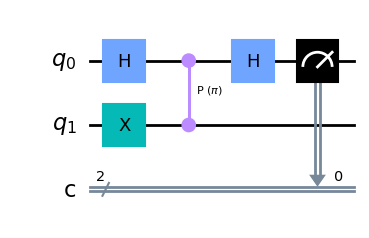

In [19]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    
    qc.h(qr[0])   
    qc.x(qr[1])
    
    qc.cp(np.pi,qr[0],qr[1])
        
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    
    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

In [20]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3a

grade_ex3a(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Paso 2

En el primer paso, medimos el bit menos significativo $\varphi_2$. En el segundo (y último) paso, extraemos el siguiente bit $\varphi_1$, que implicará aplicar una corrección de fase para cancelar la contribución de fase de $\varphi_2$. La corrección de fase depende del valor del registro clásico que contiene $\varphi_2$. ¡Necesitamos circuitos dinámicos para realizar esta retroalimentación clásica! La corrección de fase se puede aplicar usando `PhaseGate` o llamando directamente al método `p` de un QuantumCircuit.

#### Ejercicio 2

En este ejercicio, comenzamos con el circuito del Paso 1, que deberías haber construido en el Ejercicio 1.

Obtén el siguiente bit de $\varphi$ realizando los siguientes pasos:
1. Restablece y reinicia el qubit auxiliar.
2. Aplica la compuerta unitaria controlada.
3. Mide el qubit auxiliar en la base de $X$.

El circuito resultante debería verse así:

![step1-circuit](resources/step2-circuit.png)

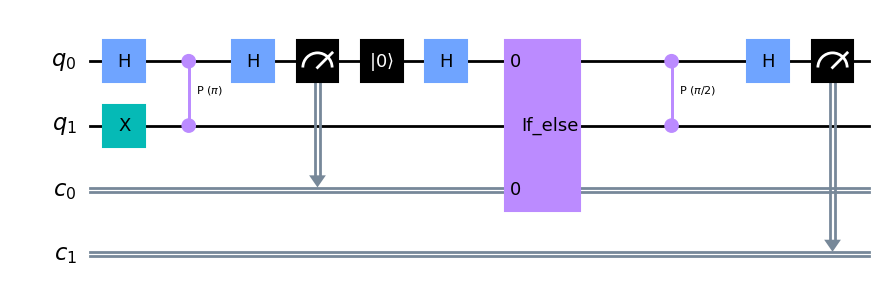

In [21]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)
    q0, q1 = qr
    c0, c1 = cr

    ####### your code goes here #######

    qc.reset(q0)
    qc.h(q0)
    
    with qc.if_test((c0,1)):
        qc.p(-(np.pi/2),0)
    qc.cp(np.pi/2, q0, q1)
    qc.h(q0)
    
    qc.measure(q0,c1)
    
    return qc
        
qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

In [22]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3b

grade_ex3b(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Ejecutar en simulador

Ahora que tenemos el circuito completo, primero vamos a ejecutarlo en un simulador local.

In [23]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

Si tu circuito es correcto, deberías haber obtenido la cadena de bits `01` con un 100% de probabilidad. Este valor corresponde a la fase escrita en binario como $\varphi = 0.01 = 1/4$. De hecho, esta es la fase correcta!

### Ejercicio 3

Construye un circuito IPE para estimar la fase de la compuerta T, cuya matriz está dada por

$$ T =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 4}
\end{pmatrix}$$

¿Cuántos bits se necesitan para representar la fase en este caso?

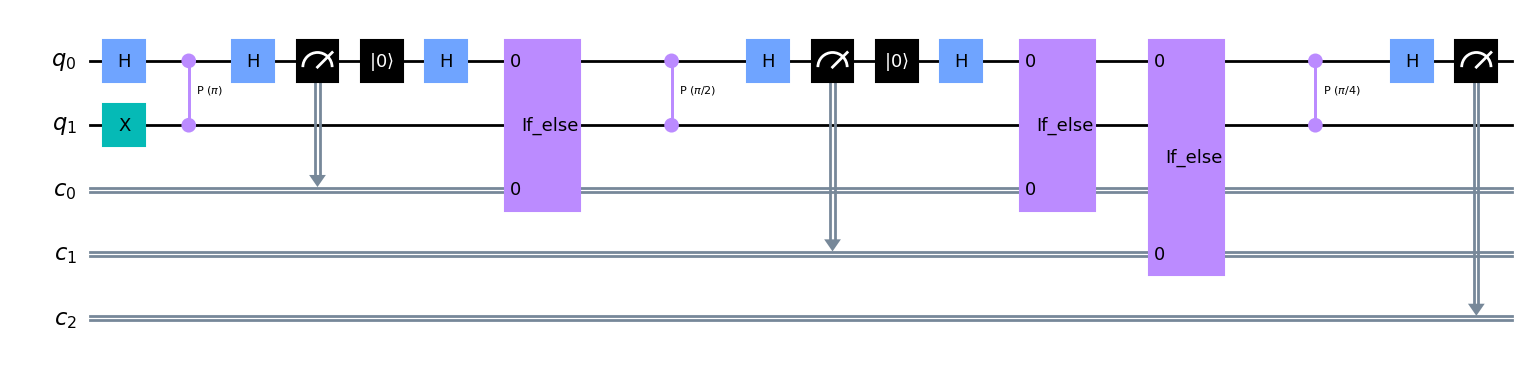

In [24]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)
     
    ####### your code goes here #######
           
    qc.h(qr[0])
    qc.x(qr[1])
    
    qc.cp(np.pi,qr[0],qr[1])
    
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    
    qc.reset(qr[0])
    qc.h(qr[0])
    
    #phase correction
    with qc.if_test((cr[0],1)):
        qc.p(-np.pi/2,qr[0])

    qc.cp(np.pi/2,qr[0],qr[1])
    
    qc.h(qr[0])
    qc.measure(qr[0],cr[1])
    
    qc.reset(qr[0])
    qc.h(qr[0])
    
    #phase correction
    with qc.if_test((cr[0],1)):
        qc.p(-np.pi/4,qr[0])
    
    with qc.if_test((cr[1],1)):
        qc.p(-np.pi/2,qr[0])
        
    qc.cp(np.pi/4,qr[0],qr[1])
    
    qc.h(qr[0])
    qc.measure(qr[0],cr[2])    
               
    
    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [25]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'001': 1000}

In [26]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3c

grade_ex3c(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Cuando la fase no tiene una expansión binaria exacta

Consideremos el caso cuando la fase no tiene una expansión binaria exacta, por ejemplo, $\varphi = 1/3$.
En este caso, la compuerta de un solo qubit tiene la matriz unitaria

$$ U =
\begin{pmatrix}
1 & 0\\
0 & e^{i2\pi / 3}
\end{pmatrix}
$$

El ángulo $\varphi = 1/3$ no tiene una expansión binaria finita exacta. Por el contrario, tiene la expansión binaria infinita

$$
1/3 = 0.010101\ldots
$$

En la práctica trabajamos con un número fijo de bits de precisión, por lo que nuestro objetivo es obtener el valor más cercano que se pueda representar con esos bits. En el siguiente ejemplo, usaremos dos bits de precisión. En este caso, el valor más cercano es $0.01 = 1/4$. Debido a que este valor no representa la fase exacta, existe cierta probabilidad de que obtengamos un resultado diferente y menos preciso.

En las siguientes celdas de código, construimos y simulamos un circuito IPE para medir la fase de esta compuerta.

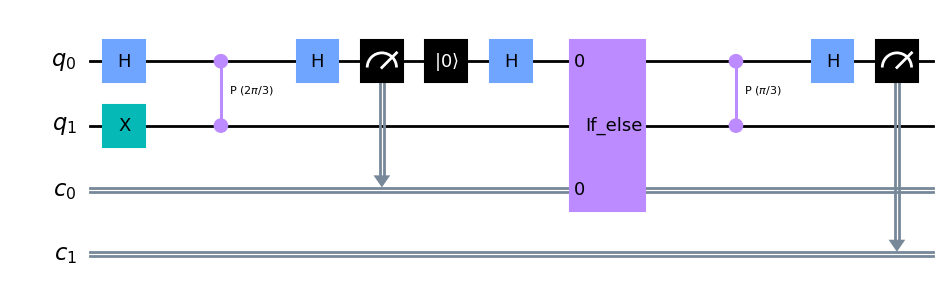

In [27]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [28]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'01': 693, '11': 62, '10': 63, '00': 182}
Success probability: 0.693


Como puedes ver, esta vez, no tenemos garatía de obtener el resultado deseado. Una pregunta natural es: ¿Cómo podemos aumentar la probabilidad de éxito?

Una forma en que el algoritmo falla es que el primer bit medido es incorrecto. En este caso, la corrección de fase aplicada antes de medir el segundo bit también es incorrecta, lo que hace que el resto de los bits también sean incorrectos. Una forma sencilla de mitigar este problema es repetir la medición de los primeros bits varias veces y obtener un voto mayoritario para aumentar la probabilidad de que midamos el bit correctamente. La implementación de este procedimiento dentro de un solo circuito requiere realizar aritmética en los resultados medidos. Debido a una limitación temporal en Qiskit, actualmente no es posible realizar operaciones aritméticas en bits medidos y condicionar futuras operaciones de circuito en los resultados. Entonces, aquí mediremos cada bit usando circuitos separados.

Las siguientes celdas de código construyen y simulan un circuito IPE para medir solo el primer bit de la fase.

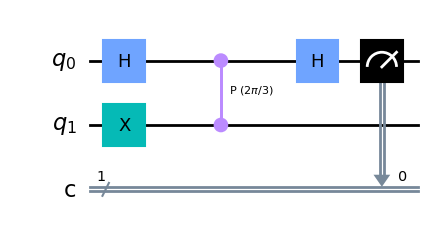

In [29]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [30]:
job = sim.run(qc, shots=15)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 4, '1': 11}


Con suerte, el bit correcto se midió la mayoría de las veces.

### Ejercicio 4

Examina el diccionario de recuentos desde la salida de la última celda de código. ¿Cuál es el valor correcto para el primer bit? ¿Se midió la mayoría de las veces? De lo contrario, vuelve a ejecutar la última celda de código hasta que lo sea. Luego, escribe un código en la celda a continuación que establezca la variable `step1_bit` igual al valor del bit que se midió la mayor parte del tiempo.

In [31]:
step1_bit: int

####### your code goes here #######

step1_bit = 1

print(step1_bit)

1


In [32]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3d

grade_ex3d(step1_bit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Ejercicio 5

Ahora construye el circuito para medir el segundo bit de la fase. Reemplaza la primera etapa del circuito con una que simplemente establezca el bit auxiliar en el valor que medimos anteriormente, de modo que siempre midamos el valor correcto para el primer bit de la fase.

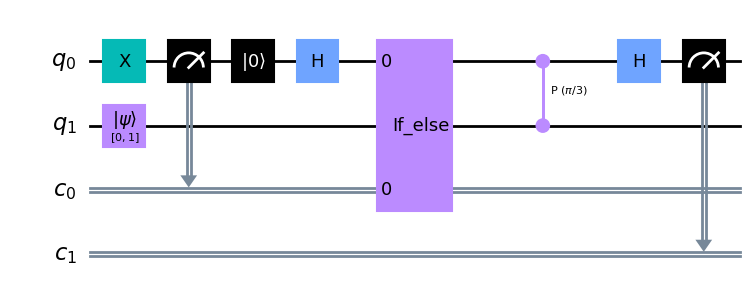

In [36]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    
    u_angle = np.pi / 3
    
    if (step1_bit == 1):
        qc.x(qr[0])
    qc.initialize([0,1],qr[1])
    qc.measure(qr[0], cr[0])

    qc.reset(qr[0])
    qc.h(qr[0])

    with qc.if_test((cr[0], 1)):
        qc.p(-np.pi / 2, qr[0])

    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, qr[0], qr[1])

    qc.h(qr[0])
    qc.measure(qr[0], cr[1])
        
    
    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [37]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3e

grade_ex3e(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [38]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 61, '01': 939}
Success probability: 0.939


¡Ahora, la probabilidad de éxito es mucho mayor que antes!

## Ejecutar en hardware

¡En la parte final de este laboratorio, ejecutaremos algunos circuitos en hardware real! Las celdas de código a continuación inicializan y ejecutan el circuito que creaste en el Ejercicio 2 para medir la fase de la compuerta $S$. Debido a que el hardware cuántico actual sufre de ruido, los resultados no serán tan buenos como los que obtuviste en el simulador. Siéntete libre de intentar ejecutar los otros circuitos que creaste en este laboratorio, aunque ten en cuenta que los circuitos más grandes, como el del Ejercicio 3 para medir la fase de la puerta $T$, sufrirán aún más ruido.

In [39]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

In [40]:
hub="qc-spring-23-2"
group="group-1"
project="recadoVo68Ok7S9J0"

backend_name = "ibm_peekskill"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [41]:
from qiskit import transpile

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc_transpiled = transpile(qc, backend)

In [42]:
job = backend.run(qc_transpiled, shots=1000, dynamic=True)
job_id = job.job_id()
print(job_id)

chkh3qs6f7i49rpnqp90


In [45]:
retrieve_job = provider.retrieve_job(job_id)
retrieve_job.status()

<JobStatus.DONE: 'job has successfully run'>

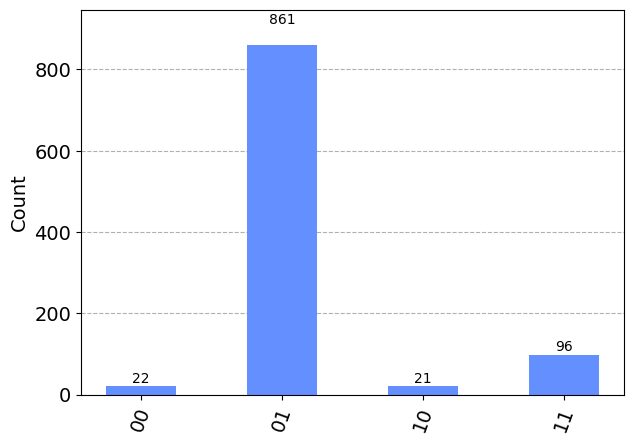

In [46]:
from qiskit.tools.visualization import plot_histogram

counts = retrieve_job.result().get_counts()
plot_histogram(counts)

Este laboratorio fue adaptado del [laboratorio del libro de texto de Qiskit](https://learn.qiskit.org/course/ch-labs/lab-6-iterative-phase-estimation-algorithm) sobre estimación de fase iterativa, así como material de la [documentación de circuitos dinámicos](https://quantum-computing.ibm.com/services/resources/docs/resources/manage/systems/dynamic-circuits/Getting-started-with-Dynamic-Circuits).